## AUTO ML CLASSIFICATION MODEL WITH RAPIDS

#### WITHOUT CANADA
#### ONLY SMALL SUBSET OF FEATURES
#### MAXABSSCALER AND XGB
#### PRECISION 0.84 = RECALL 0.85 = ACCURACY 0.85

In [1]:
# !pip install gdown
# !mkdir data
# !cd data
# !gdown 1D0goLpsXELNET-tzcn_nJutXVBaF-EYR
# !unzip csv_for_ml.zip

In [2]:
# #!conda init bash
# !conda activate rapids-22.02
# !python3 -c "import cudf, cuml; print(cudf.__version__); print(cuml.__version__)"
# !conda deactivate

In [3]:
import pandas as pd
from functools import reduce

In [4]:
business = pd.read_csv('./data/business.csv')
attributes = pd.read_csv('./data/atributtes_clean.csv', low_memory=False)
categories = pd.read_csv('./data/categories_fixed.csv')
hours = pd.read_csv('./data/hours_fixed.csv')
gps = pd.read_csv('./data/gps_clustering.csv')
checkins = pd.read_csv('./data/n_checkins.csv')
top_tips = pd.read_csv('./data/top_tips.csv')
target2 = pd.read_csv('./data/target2.csv')
sentiment = pd.read_csv('./data/sentiment_ok_unique.csv')

In [5]:
data_frames = [business, attributes, categories, hours, gps, checkins, top_tips, target2]
full_data_2 = reduce(lambda left,right: pd.merge(left,right,on='business_id', how='left'), data_frames)

In [6]:
full_data_2.columns

Index(['business_id', 'name', 'postal_code', 'latitude_x', 'longitude_x',
       'stars', 'review_count', 'is_open', 'good_ambience', 'garage',
       'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'BikeParking',
       'WiFi', 'delivery', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsReservations', 'HasTV', 'RestaurantsGoodForGroups',
       'Alcohol', 'ByAppointmentOnly', 'Caters', 'RestaurantsAttire',
       'NoiseLevel', 'meal_diversity', 'Restaurants', 'Food', 'Shopping',
       'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical',
       'Local Services', 'Bars', 'Automotive', 'total_categories', '7days',
       'weekends', 'n_open_days', 'mean_total_hours_open', 'mean_open_hour',
       'mean_close_hour', 'latitude_y', 'longitude_y', 'areas',
       'number_visits', 'number_tips', 'Unnamed: 0', 'success_score_2',
       'target'],
      dtype='object')

In [7]:
to_drop = ['name', 'postal_code', 'latitude_x', 'longitude_x', 'stars', 'review_count', 'is_open', 'latitude_y', 'longitude_y',  'number_visits', 'number_tips', 'Unnamed: 0', '7days', 'n_open_days', 'total_categories', 'mean_open_hour', 'mean_close_hour','success_score_2']#, 'target' ]
full_data_2.drop(to_drop, inplace=True, axis=1)

In [8]:
full_data_2 = full_data_2.loc[full_data_2['areas'] != 7, :]

In [9]:
full_data_2.index = full_data_2['business_id']
full_data_2.drop('business_id', axis=1, inplace=True)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#from functions import run_exps

import warnings
warnings.filterwarnings('ignore') 

In [11]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

full_data_2['mean_total_hours_open'] = mice_imputer.fit_transform(full_data_2['mean_total_hours_open'].values.reshape(-1,1))

In [12]:
full_data_2.fillna(0, inplace=True)

In [13]:
full_data_3 = full_data_2.copy()

In [14]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['areas', 'RestaurantsPriceRange2']
X = ohe.fit_transform(full_data_2[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names(to_transform), index=full_data_2.index)
full_data_2 = pd.concat([full_data_2, X], axis=1)
full_data_2.drop(to_transform, axis=1, inplace=True)

In [15]:
full_data_2.shape

(145875, 45)

In [16]:
full_data_2.isna().sum().sum()

0

In [17]:
#!pip install wandb
#import wandb
#wandb.init(project="henry-tf-g2-ml1")

In [19]:
!pip install tpot
import tpot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 24.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=323ebf545197adeea70b86584199f20c5e09c389f409c2665ba0f0f708900527
  Stored in directory: /root/.cache/pip/wheels/3f/2c/f9/411eea50089f1313eb80637f6107ec839721f6e36679050160
Successfully built stopit


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_2.drop('target', axis=1), full_data_2['target'], test_size=0.2,
    random_state=42)

In [21]:
full_data_2.to_csv('./data/automl_gpu_7.csv', index = True)

In [22]:
# pipeline_optimizer = tpot.TPOTClassifier(generations=5, #number of iterations to run the training
#                                         population_size=20, #number of individuals to train
#                                         cv=10, max_time_mins = 100,
#                                         config_dict="TPOT cuML") #number of folds in StratifiedKFold
# pipeline_optimizer.fit(X_train, y_train) #fit the pipeline optimizer - can take a long time

# print(pipeline_optimizer.score(X_test, y_test)) #print scoring for the pipeline
# pipeline_optimizer.export('automl_pipeline_gpu_class.py') #export the pipeline - in Python code!

In [23]:
!pip install wandb plotly
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 67.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 15.6 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=034e2d0e3a79f28483f8308fdafd7fb7c5ff35835cffc7fc5f303b0f0f348fec
  Stored in directory: /root/.cache/pip/wheels/68/ee/8d/57af0d8b0d34c2e918ff29d3af02b348db6499bb107caa007e
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=efd78146035580520d70c4674aef94fee15919972cbb2c4e8295df552f19374c
  Stored in directory: /root/.cache/pip/wheels/20/7c/09/4ad42725a29fce4bc21137c7f25f062b3655a

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from xgboost import XGBClassifier

# Average CV score on the training set was: 0.8492544987146529
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    XGBClassifier(alpha=10, learning_rate=0.1, max_depth=8, min_child_weight=6, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, tree_method="gpu_hist", verbosity=0)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

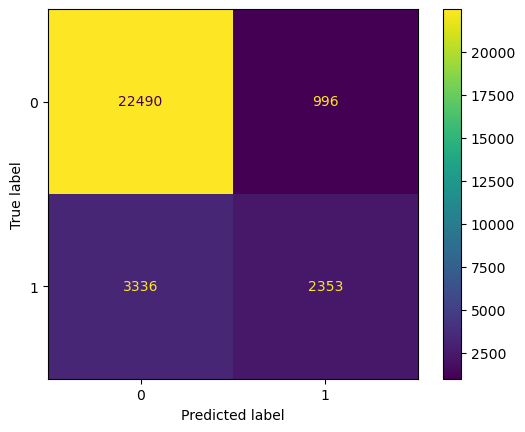

[[22490   996]
 [ 3336  2353]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     23486
           1       0.70      0.41      0.52      5689

    accuracy                           0.85     29175
   macro avg       0.79      0.69      0.72     29175
weighted avg       0.84      0.85      0.84     29175



In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, results)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, results))
print(classification_report(y_test, results))

ValueError: tree must be Booster, XGBModel or dict instance

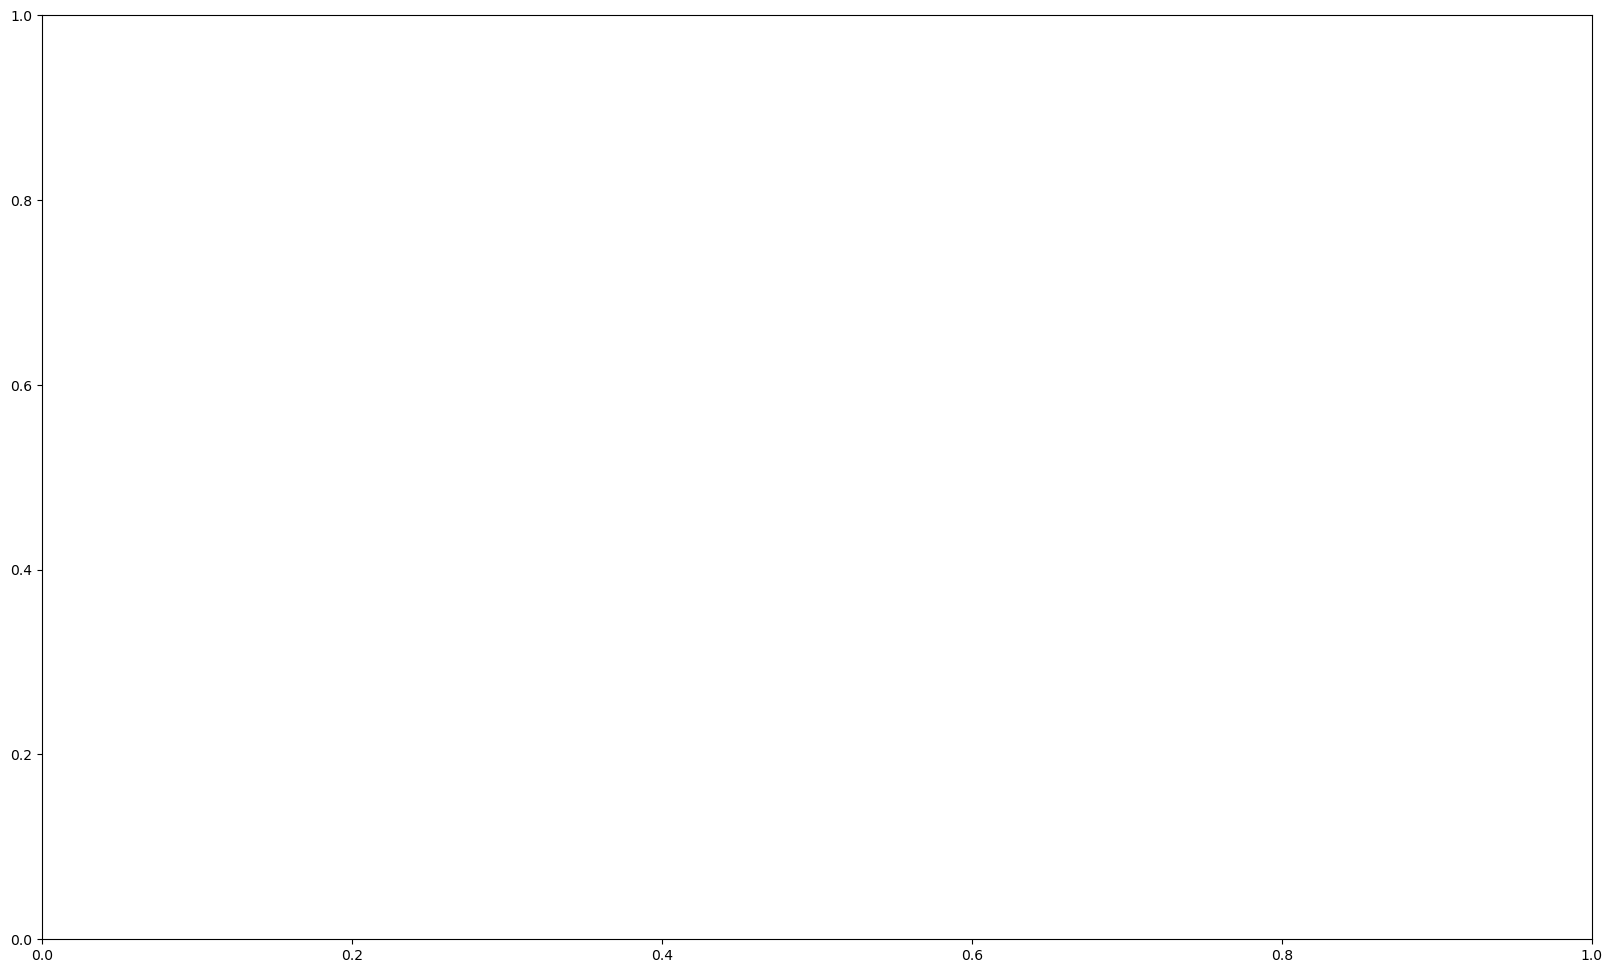

In [26]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') 
# Plot the feature importances
fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(exported_pipeline, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, results)

In [ ]:
# OR to log a final metric at the end of training you can also use wandb.summary
wandb.summary["accuracy"] = accuracy

In [ ]:
# OR to log a final metric at the end of training you can also use wandb.summary
wandb.summary["accuracy"] = accuracy
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_test, results)